In [23]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
import numpy as np

import cv2
from scipy.stats import entropy
from tqdm import tqdm

In [2]:
DATA_ROOT_PATH = Path('/data/k_water/dataset')
DATA_ROOT_PATH_TRAIN = DATA_ROOT_PATH / 'train'
DATA_ROOT_PATH_TEST = DATA_ROOT_PATH / 'test'

TRAIN_DATA_IMAGE = sorted(DATA_ROOT_PATH_TRAIN.rglob("train_*.png"))
TEST_DATA_IMAGE = sorted(DATA_ROOT_PATH_TEST.rglob("test_*.png"))
TRAIN_DATA_ANNOT = DATA_ROOT_PATH / "labels" / "train.json"

ANSWER_SAMPLE = DATA_ROOT_PATH / "labels" / "answer_sample.json"

## Image dataset

In [3]:
print("The number of train images : \t", len(TRAIN_DATA_IMAGE))
print("The number of test images : \t",len(TEST_DATA_IMAGE))

The number of train images : 	 104875
The number of test images : 	 44946


# COCO API

In [4]:
coco=COCO(TRAIN_DATA_ANNOT)
print(coco)
"""
getAnnIds: Get ann ids that satisfy given filter conditions.
getCatIds: Get cat ids that satisfy given filter conditions.
getImgIds: Get img ids that satisfy given filter conditions.
loadAnns: Load anns with the specified ids.
loadCats: Load cats with the specified ids.
loadImgs: Load imgs with the specified ids.
showAnns: Display the specified annotations.
"""

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


'\ngetAnnIds: Get ann ids that satisfy given filter conditions.\ngetCatIds: Get cat ids that satisfy given filter conditions.\ngetImgIds: Get img ids that satisfy given filter conditions.\nloadAnns: Load anns with the specified ids.\nloadCats: Load cats with the specified ids.\nloadImgs: Load imgs with the specified ids.\nshowAnns: Display the specified annotations.\n'

In [5]:
coco.loadCats(coco.getCatIds())

[{'id': 0, 'name': '농어', 'supercategory': ''},
 {'id': 1, 'name': '베스', 'supercategory': ''},
 {'id': 2, 'name': '숭어', 'supercategory': ''},
 {'id': 3, 'name': '강준치', 'supercategory': ''},
 {'id': 4, 'name': '블루길', 'supercategory': ''},
 {'id': 5, 'name': '잉어', 'supercategory': ''},
 {'id': 6, 'name': '붕어', 'supercategory': ''},
 {'id': 7, 'name': '누치', 'supercategory': ''}]

In [6]:
NUM_CLASS = len(coco.getCatIds())

In [7]:
print("Num of images")
for i in range(NUM_CLASS):
    print(i, len(coco.getImgIds(catIds=i)))

print("Num of annots")
for i in range(NUM_CLASS):
    print(i, len(coco.getAnnIds(catIds=i)))

Num of images
0 156
1 2243
2 544
3 1721
4 97
5 158
6 131
7 586
Num of annots
0 180
1 2344
2 651
3 2132
4 101
5 159
6 148
7 586


In [8]:
coco.loadImgs(1)

[{'id': 1,
  'width': 640,
  'height': 480,
  'file_name': 'train_0.png',
  'license': 0,
  'flickr_url': '',
  'coco_url': '',
  'date_captured': 0}]

In [9]:
coco.loadAnns(1)

[{'id': 1,
  'image_id': 1,
  'category_id': 3,
  'segmentation': [],
  'area': 40939.4791,
  'bbox': [37.98, 209.94, 369.19, 110.89],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [10]:
coco.loadCats(1)

[{'id': 1, 'name': '베스', 'supercategory': ''}]

## Plot a pair of image and annotation.

In [11]:
def plot_single_image(i_class, idx):
    catIds = coco.getCatIds(catIds=[i_class]) 
    ids = coco.getImgIds(catIds = catIds)
    imgIds = ids[idx]
    annIds = coco.getAnnIds(imgIds = imgIds, catIds = catIds)

    # annot
    anns = coco.loadAnns(annIds)

    # image
    imgInfo = coco.loadImgs(imgIds)
    image = Image.open(os.path.join(str(DATA_ROOT_PATH_TRAIN), imgInfo[0]['file_name'])\
                       ).convert('RGB')
    
    # show
    plt.imshow(image)
    coco.showAnns(anns, draw_bbox = True)

    return imgIds, annIds


def plot_multiple_images(idx = 0):
    plt.figure(figsize=(10, 40))
    for i_class in range(NUM_CLASS):
        plt.subplot(NUM_CLASS, 1, i_class + 1)
        imgIds, annIds = plot_single_image(i_class, idx)

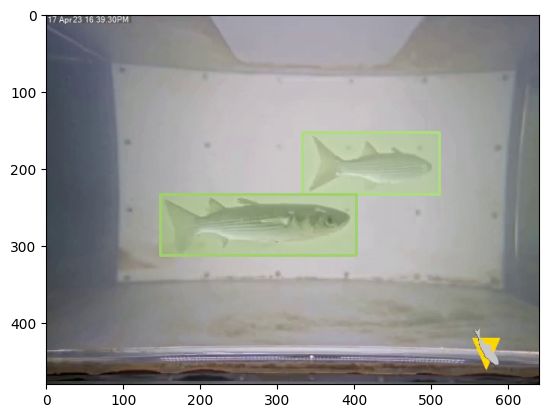

In [12]:
imgIds, annIds = plot_single_image(i_class=2, idx=2)

In [13]:
coco.loadAnns(annIds)

[{'id': 111,
  'image_id': 2097,
  'category_id': 2,
  'segmentation': [],
  'area': 14539.187599999996,
  'bbox': [331.92, 151.33, 178.22, 81.58],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}},
 {'id': 112,
  'image_id': 2097,
  'category_id': 2,
  'segmentation': [],
  'area': 20403.2,
  'bbox': [147.37, 232.12, 255.04, 80.0],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

In [14]:
# check if attrs(iscrowd, occluded, rotation) are available info.
for i in range(NUM_CLASS):
    annIds = coco.getAnnIds(catIds=i)
    print(f"class {i}", len(annIds))
    for annId in annIds: 
        ann = coco.loadAnns(annId)
        annot_info = ann[0]

        iscrowd = annot_info['iscrowd']
        occluded = annot_info['attributes']['occluded']
        rotation = annot_info['attributes']['rotation']

        if iscrowd:
            print(iscrowd)
        if occluded:
            print(occluded)
        if rotation:
            print(rotation)


class 0 180
class 1 2344
class 2 651
class 3 2132
class 4 101
class 5 159
class 6 148
class 7 586


In [15]:
ann

[{'id': 8627,
  'image_id': 140238,
  'category_id': 7,
  'segmentation': [],
  'area': 36558.70939999999,
  'bbox': [82.27, 261.56, 287.66, 127.09],
  'iscrowd': 0,
  'attributes': {'occluded': False, 'rotation': 0.0}}]

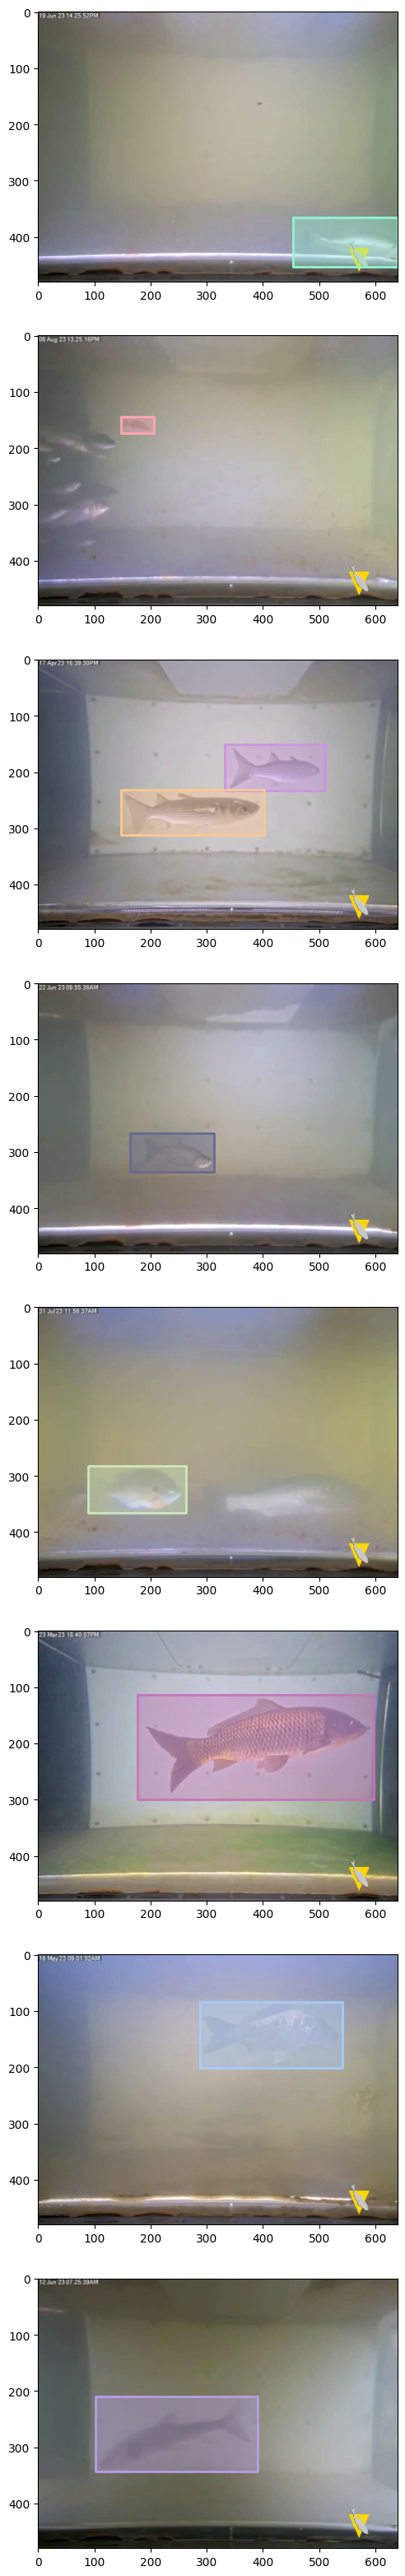

In [16]:
plot_multiple_images(idx=2)

## Analysis of Image-level information

- num annots per image
- average area per image
- image pixel-level info, e.g., brightness or entropy
- if 'k' class instance does exist

평균: 0.06008104886769964
중앙값: 0.0
최댓값: 8
최솟값: 0
0 이상 카운팅: 104875
1 이상 카운팅: 5561
2 이상 카운팅: 511
3 이상 카운팅: 132
4 이상 카운팅: 54
5 이상 카운팅: 27
6 이상 카운팅: 9
7 이상 카운팅: 5
8 이상 카운팅: 2
9 이상 카운팅: 0


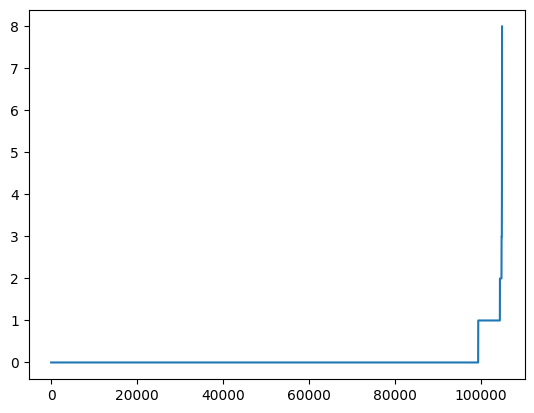

In [17]:
# num annots per image
img_ids = coco.getImgIds()
list_num_annot = list()
for id in img_ids:
    list_num_annot.append(len(coco.getAnnIds(imgIds = [id])))

mean = np.mean(list_num_annot)
median = np.median(list_num_annot)
max_value = np.max(list_num_annot)
min_value = np.min(list_num_annot)

print(f"평균: {mean}")
print(f"중앙값: {median}")
print(f"최댓값: {max_value}")
print(f"최솟값: {min_value}")
for i in range(10):
    print(f"{i} 이상 카운팅: {sum(1 for num in list_num_annot if num >= i)}")

list_num_annot.sort()
plt.plot(list_num_annot)

## 0 vs. the else
## 3 이상 vs. the else
## 5 이상 vs. the else

평균: 1203.6482606190466
중앙값: 0.0
최댓값: 151957.6744
최솟값: 0.0
0 	 이상 카운팅: 104875
5000 	 이상 카운팅: 5492
10000 	 이상 카운팅: 4561
15000 	 이상 카운팅: 3405
20000 	 이상 카운팅: 2507
25000 	 이상 카운팅: 1829
30000 	 이상 카운팅: 1321
35000 	 이상 카운팅: 914
40000 	 이상 카운팅: 646
45000 	 이상 카운팅: 454
50000 	 이상 카운팅: 334
55000 	 이상 카운팅: 251
60000 	 이상 카운팅: 191
65000 	 이상 카운팅: 140
70000 	 이상 카운팅: 106
75000 	 이상 카운팅: 80
80000 	 이상 카운팅: 60
85000 	 이상 카운팅: 46
90000 	 이상 카운팅: 32
95000 	 이상 카운팅: 26


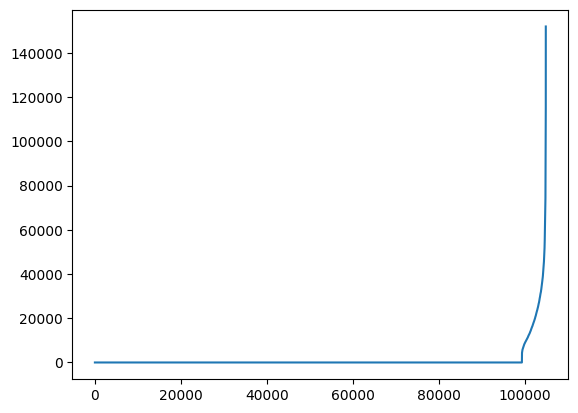

In [19]:
# average area of instances per image
img_ids = coco.getImgIds()
list_area = list()
for id in img_ids:
    annIds = coco.getAnnIds(imgIds = [id])
    _area = list()
    for annId in annIds:
        ann = coco.loadAnns(annId)[0]
        _area.append(ann['area'])
    if len(_area) == 0 :
        list_area.append(0)
    else:
        list_area.append(np.mean(_area))

mean = np.mean(list_area)
median = np.median(list_area)
max_value = np.max(list_area)
min_value = np.min(list_area)

print(f"평균: {mean}")
print(f"중앙값: {median}")
print(f"최댓값: {max_value}")
print(f"최솟값: {min_value}")

for i in range(0, 100000, 5000):
    print(f"{i} \t 이상 카운팅: {sum(1 for num in list_area if num >= i)}")

list_area.sort()
plt.plot(list_area)

## 0 vs. the else
## 50000 이상 vs. the else
## 80000 이상 vs. the else

In [24]:
# image entropy
img_ids = coco.getImgIds()
list_entrophy = list()
for id in tqdm(img_ids):
    imgInfo = coco.loadImgs(id)
    image = Image.open(os.path.join(str(DATA_ROOT_PATH_TRAIN), imgInfo[0]['file_name'])\
                       ).convert('RGB')
    image_entropy = entropy(image, base=2)
    list_entrophy.append(image_entropy)

mean = np.mean(list_entrophy)
median = np.median(list_entrophy)
max_value = np.max(list_entrophy)
min_value = np.min(list_entrophy)

print(f"평균: {mean}")
print(f"중앙값: {median}")
print(f"최댓값: {max_value}")
print(f"최솟값: {min_value}")

for i in range(0, 100000, 5000):
    print(f"{i} \t 이상 카운팅: {sum(1 for num in list_entrophy if num >= i)}")

list_entrophy.sort()

## 0 vs. the else
## 50000 이상 vs. the else
## 80000 이상 vs. the else

 44%|████▎     | 45657/104875 [08:38<11:21, 86.92it/s]

In [ ]:
# if 'k' class instance does exist
img_ids = coco.getImgIds()
dict_info = list()
for id in img_ids:
    annIds = coco.getAnnIds(imgIds = [id])
    _area = list()
    for annId in annIds:
        ann = coco.loadAnns(annId)[0]
        _area.append(ann['area'])
    if len(_area) == 0 :
        list_area.append(0)
    else:
        list_area.append(np.mean(_area))


## 0 vs. the else
## 50000 이상 vs. the else
## 80000 이상 vs. the else